In [9]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling & Metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# XGBoost & Bayesian Optimization
import xgboost as xgb
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# Partial Dependence
from sklearn.inspection import PartialDependenceDisplay

# SHAP
import shap
shap.initjs()

# Utility Functions

In [10]:
def bayesian_optimize_xgb(X, y, n_iter=25, cv_splits=3):
    """
    Performs Bayesian hyperparameter optimization for an XGBoost classifier using BayesSearchCV.
    """
    xgb_estimator = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
    
    # Define hyperparameter search space
    param_spaces = {
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'max_depth': Integer(2, 10),
        'min_child_weight': Integer(1, 10),
        'subsample': Real(0.5, 1.0),
        'colsample_bytree': Real(0.5, 1.0),
        'n_estimators': Integer(50, 500),
        'gamma': Real(0, 5),
        'reg_alpha': Real(1e-5, 10, prior='log-uniform'),
        'reg_lambda': Real(1e-5, 10, prior='log-uniform')
    }

    bayes_cv = BayesSearchCV(
        estimator=xgb_estimator,
        search_spaces=param_spaces,
        n_iter=n_iter,
        scoring='accuracy',
        cv=StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42),
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    
    bayes_cv.fit(X, y)
    
    print("Best Score during optimization:", bayes_cv.best_score_)
    print("Best Params:", bayes_cv.best_params_)
    
    return bayes_cv.best_estimator_, bayes_cv

# Data Preparation

In [11]:
def load_and_prepare_data(csv_path='bank/bank-full.csv'):
    """
    Loads the Bank Marketing Dataset (full version) with the following columns:
       1 - age (numeric)
       2 - job (categorical)
       3 - marital (categorical)
       4 - education (categorical)
       5 - default (binary cat)
       6 - balance (numeric)
       7 - housing (binary cat)
       8 - loan (binary cat)
       9 - contact (categorical)
      10 - day (numeric)
      11 - month (categorical: "jan","feb","mar",...,"dec")
      12 - duration (numeric)
      13 - campaign (numeric)
      14 - pdays (numeric)
      15 - previous (numeric)
      16 - poutcome (categorical: "unknown","other","failure","success")
      17 - y (target binary: "yes","no")

    - Replaces 'unknown' with NaN, then drops those rows.
    - Label-encodes categorical features.
    - Converts 'y' to 0/1 (yes->1, no->0).
    Returns: X, y, df
    """
    df = pd.read_csv(csv_path, sep=';')
    
    # Replace 'unknown' with NaN, then drop those rows
    df = df.replace('unknown', np.nan).dropna()
    
    # Convert target: yes -> 1, no -> 0
    df['y'] = df['y'].map({'yes': 1, 'no': 0})
    
    # Identify categorical vs numeric columns
    # We expect day, age, balance, duration, campaign, pdays, previous to be numeric
    # job, marital, education, default, housing, loan, contact, month, poutcome to be categorical
    # but let's do it programmatically:
    cat_cols = []
    num_cols = []
    for col in df.columns:
        if col == 'y':
            continue
        if df[col].dtype == 'object':
            cat_cols.append(col)
        else:
            num_cols.append(col)
    
    # Label-encode all categorical cols
    for c in cat_cols:
        le = LabelEncoder()
        df[c] = le.fit_transform(df[c].astype(str))
        # If you want to revert codes to categories, store the encoders somewhere.

    # Create X, y
    X = df.drop(columns=['y'])
    y = df['y'].values
    
    return X, y, df

X, y, df_full = load_and_prepare_data('bank/bank-full.csv')
print("Data loaded.")
print("X shape:", X.shape, "| y shape:", y.shape)
df_full.head()

Data loaded.
X shape: (7842, 16) | y shape: (7842,)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
24060,33,0,1,2,0,882,0,0,1,21,10,39,1,151,3,0,0
24062,42,0,2,1,0,-247,1,1,1,21,10,519,1,166,1,1,1
24064,33,7,1,1,0,3444,1,0,1,21,10,144,1,91,4,0,1
24072,36,4,1,2,0,2415,1,0,1,22,10,73,1,86,4,1,0
24077,36,4,1,2,0,0,1,0,1,23,10,140,1,143,3,0,1


# Train-Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (6273, 16) (6273,)
Test shapes: (1569, 16) (1569,)


# Question 1: Who to Contanct?


=== Part 1: Who to Contact? ===
Best Score during optimization: 0.8560497369679578
Best Params: OrderedDict([('colsample_bytree', 0.9061979941786817), ('gamma', 0.8593578069828035), ('learning_rate', 0.07645185888630145), ('max_depth', 8), ('min_child_weight', 6), ('n_estimators', 93), ('reg_alpha', 0.34261249458638526), ('reg_lambda', 1.721004951589103), ('subsample', 0.9559644307534418)])
Confusion Matrix:
 [[1110  102]
 [ 131  226]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91      1212
           1       0.69      0.63      0.66       357

    accuracy                           0.85      1569
   macro avg       0.79      0.77      0.78      1569
weighted avg       0.85      0.85      0.85      1569

Number of customers recommended to contact: 328 / 1569


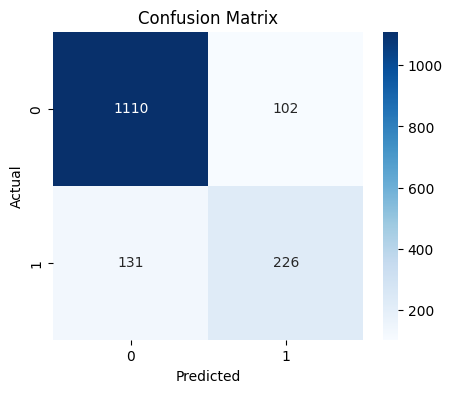

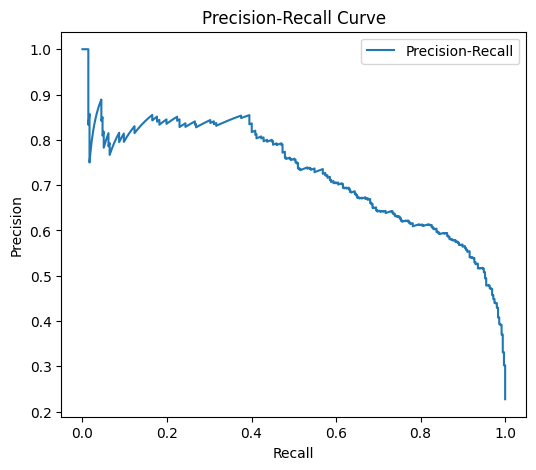

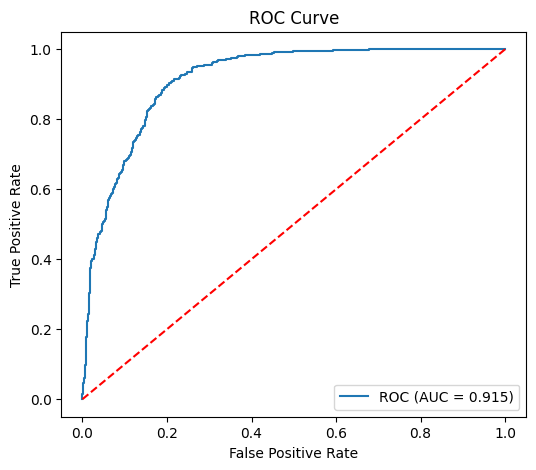

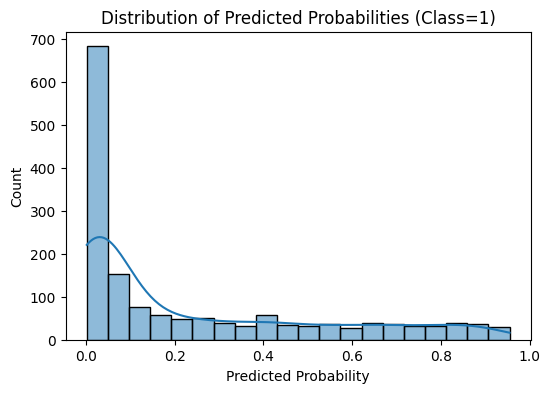

In [13]:
def part1_who_to_contact(X_train, y_train, X_test, y_test):
    """
    Trains an XGBoost model with Bayesian optimization to identify
    which customers to contact (predicted to subscribe).
    """
    print("\n=== Part 1: Who to Contact? ===")
    
    best_model, _ = bayesian_optimize_xgb(X_train, y_train, n_iter=20, cv_splits=3)
    
    # Predictions
    y_pred = best_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    # Probability for class=1
    probs = best_model.predict_proba(X_test)[:,1]
    contact_threshold = 0.5
    to_contact = (probs >= contact_threshold).astype(int)
    print(f"Number of customers recommended to contact: {to_contact.sum()} / {len(to_contact)}")
    
    # Visualization: Confusion Matrix Heatmap
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, label='Precision-Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()
    
    # ROC Curve
    fpr, tpr, roc_thresholds = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})')
    plt.plot([0,1],[0,1], 'r--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
    
    # Distribution of predicted probabilities
    plt.figure(figsize=(6,4))
    sns.histplot(probs, kde=True, bins=20)
    plt.title("Distribution of Predicted Probabilities (Class=1)")
    plt.xlabel("Predicted Probability")
    plt.show()
    
    return best_model

best_model = part1_who_to_contact(X_train, y_train, X_test, y_test)


## Overall Accuracy & AUC
- Accuracy: ~85% on the test set.
- ROC AUC: ~0.915, which indicates strong discriminative power (the model can generally distinguish positives from negatives quite well).

This suggests the model is performing significantly better than random in identifying which customers are likely to subscribe.

## Confusion Matrix & Classification Report
- True Negatives (TN): 1110
- False Positives (FP): 102
- False Negatives (FN): 131
- True Positives (TP): 226

From the classification report:
» Class 0 (“no”):
- Precision = 0.89, Recall = 0.92, F1 = 0.91
- The model does a solid job of correctly predicting “no” (few false positives).
» Class 1 (“yes”):
- Precision = 0.69, Recall = 0.63, F1 = 0.66
- The model’s performance on the positive class is more moderate. It catches 63% of actual positives, so some “yes” customers are missed (false negatives).

**Takeaway:**
The model captures most negatives correctly (~92% recall for “no”) but are less perfect at spotting “yes” (~63% recall). This is typical for an imbalanced scenario where the positive class is smaller.

## Precision-Recall Curve
- The precision starts near 1.0 but drops as you increase recall, illustrating the typical trade-off.
- For more positives (higher recall), we can lower our decision threshold, but that will reduce precision.

**Business Implication:**
- If our goal is to minimise missed opportunities (i.e.,we want to capture more “yes”), we should consider tuning the threshold to increase recall (but expect more false positives).
- If our your goal is to maintain high precision (avoid wasted contacts), keep the threshold higher.

## Predicted Probability Distribution
- Most probabilities are heavily skewed near 0, meaning the model is very confident that a majority of customers are “no.”
- A relatively small proportion have probabilities above 0.5 (leading to 328 recommended contacts out of 1569).

**Takeaway:**
- The model identifies a subset of customers with higher subscription likelihood.
- This can be beneficial if our marketing budget is limited, as we can focus on the ~21% who are above the 0.5 probability threshold.

## Key Insights & Next Steps
1. Good Discrimination: An AUC of ~0.915 is strong, suggesting the model separates “yes” vs. “no” well overall.
2. Class Imbalance: The positive class metrics (precision 0.69, recall 0.63) are decent but could improve if capturing all positives is a priority. We should consider:
- Threshold Tuning: Lower the threshold to boost recall (catch more positives).
- scale_pos_weight in XGBoost or class weighting if positive cases are relatively rare.
3. Business Application:
- With a default threshold of 0.5, we’ll contact 328 customers out of 1569 (about 21%).
- Evaluate whether we want fewer contacts (and accept more missed positives) or more contacts (and accept more false alarms).
4. Further Analysis:
- Look at cost-benefit: If contacting a customer is relatively cheap compared to the potential gain, we might prefer a lower threshold to ensure fewer missed opportunities.
- Assess precision-recall at various thresholds to find the best operating point for our marketing objectives.

# Question 2: When to Contact?


=== Part 2: When to Contact? ===

Top 10 Feature Importances:
      feature  importance
15   poutcome    0.506336
6     housing    0.118602
11   duration    0.091378
7        loan    0.048366
13      pdays    0.031742
10      month    0.029645
8     contact    0.024301
9         day    0.021637
3   education    0.021503
1         job    0.019305


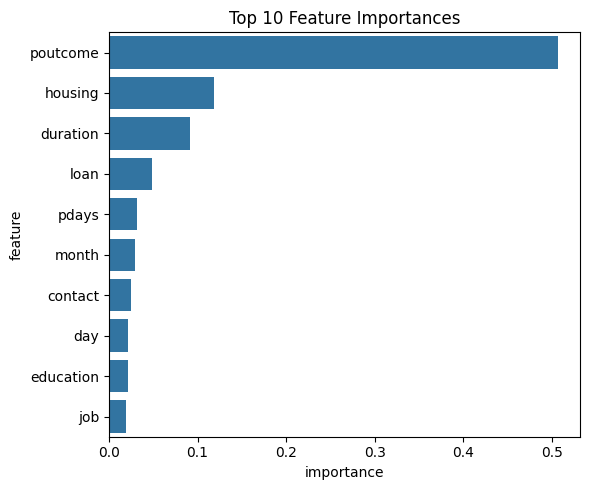


Partial Dependence Plot for 'month'...


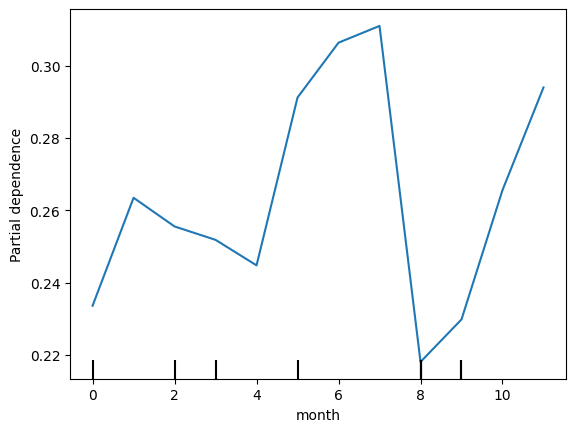


Partial Dependence Plot for 'day' (numeric day of month)...


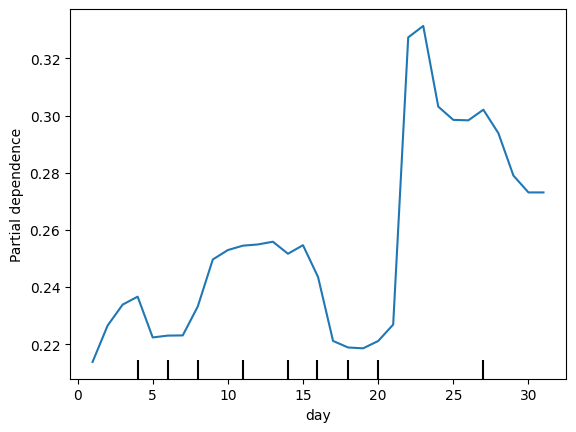

In [14]:
def part2_when_to_contact(model, X, df):
    """
    Analyze time-related features (month, day) via feature importances and partial dependence.
    """
    print("\n=== Part 2: When to Contact? ===")
    
    feature_importances = model.feature_importances_
    feature_names = list(df.drop(columns=['y']).columns)
    
    fi_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Feature Importances:")
    print(fi_df.head(10))
    
    # Bar plot
    plt.figure(figsize=(6,5))
    sns.barplot(x='importance', y='feature', data=fi_df.head(10))
    plt.title("Top 10 Feature Importances")
    plt.tight_layout()
    plt.show()
    
    # For partial dependence, let's check 'month' (categorical) & 'day' (numeric).
    # Both are label-encoded if they were originally categories/strings.
    if 'month' in feature_names:
        print("\nPartial Dependence Plot for 'month'...")
        try:
            PartialDependenceDisplay.from_estimator(model, X, features=['month'], kind='average')
            plt.show()
        except Exception as e:
            print(f"Partial Dependence Error for month: {e}")
    
    if 'day' in feature_names:
        print("\nPartial Dependence Plot for 'day' (numeric day of month)...")
        try:
            PartialDependenceDisplay.from_estimator(model, X, features=['day'], kind='average')
            plt.show()
        except Exception as e:
            print(f"Partial Dependence Error for day: {e}")

part2_when_to_contact(best_model, X_test, df_full)


## Top Feature Importances
- poutcome dominates at ~0.506, overshadowing other features in determining when and how likely a customer is to subscribe.
- housing, duration, loan, and pdays follow as moderate influences.
- month and day appear further down the list, indicating they still matter, but less so than campaign-oriented features (like poutcome) or financial attributes (like housing loan).

**Key Insight**
Because “poutcome” is extremely influential, the success or failure of a previous campaign plays a bigger role than just the calendar day/month in deciding whether now is a good time to contact a customer. However, month and day still show variation in partial dependence, so there are some time-based patterns worth noting.

## Partial Dependence Plot for month
- The partial dependence line fluctuates between roughly 0.22 and 0.32 across the encoded “month” values.
- Some months (likely around label-coded 5–7) show rising subscription probability up to ~0.31 or 0.32, then there's a steep drop around label-coded 8, followed by another climb near 10–11.

**Interpretation**
1. Higher PD (~0.30+) means the model predicts greater probability of subscription in certain months.
2. The sharp dip around one specific month indicates a period where predicted success is lower, perhaps due to seasonal effects or past campaign performance in that month.
3. Because months are label-encoded, we’ll want to confirm which numeric code maps to which month (e.g., 8 might be August or September). Then we can plan outreach campaigns more heavily during the months with higher partial dependence.

## Partial Dependence Plot for day (day of the month)
- The partial dependence hovers around 0.22–0.26 for days 1–17, then dips briefly near 17–18, before jumping to ~0.32 around days 20–21.
- After that peak, it tapers slightly but remains ~0.28–0.30 for days 22–25, then edges down to ~0.27–0.26 by day 30.

**Interpretation**
1. There’s a notable surge in subscription probability after about day 19 or 20 of the month.
2. Earlier days of the month (1–10) show moderately lower partial dependence, though not drastically so.
3. This suggests contacting customers in the later part of the month (roughly days 20–25) might yield a better response rate, all else being equal.

## Key Takeaways / Recommendations
1. Focus on Poutcome First
With “poutcome” carrying so much weight, we should consider segmenting or prioritizing contacts based on whether they had a successful or failed outcome in a previous campaign.
2. Seasonal or Monthly Timing
- The month curve implies certain months have higher predicted success. We should identify which labels correspond to those higher points (e.g., “July,” “August,” “November”) and adjust our outreach schedule accordingly.
- We should avoid months with steep dips in the partial dependence curve if possible, or try to double down on marketing strategies that mitigate seasonal effects in those low-response months.
3. Day-of-Month Strategy
- The model suggests mid-to-late month (around days 20–25) is a better time to reach out.
- Re-check your domain knowledge: Are customers more willing to commit after certain pay cycles, or ahead of certain monthly deadlines?
4. Combine Time with Other Key Variables
- Housing, duration, and loans are also important. For instance, if someone doesn’t have a housing loan, they might respond differently to monthly timing.
- We should consider using advanced plots (interaction partial dependence or SHAP interaction) if we want to see how month or day interacts with top features like “housing” or “poutcome.”


# Qestion 3: How to Personalise Communication?


=== Part 3: How to Personalize Communication? ===

Top 10 features (XGBoost importance):
      feature  importance
15   poutcome    0.506336
6     housing    0.118602
11   duration    0.091378
7        loan    0.048366
13      pdays    0.031742
10      month    0.029645
8     contact    0.024301
9         day    0.021637
3   education    0.021503
1         job    0.019305


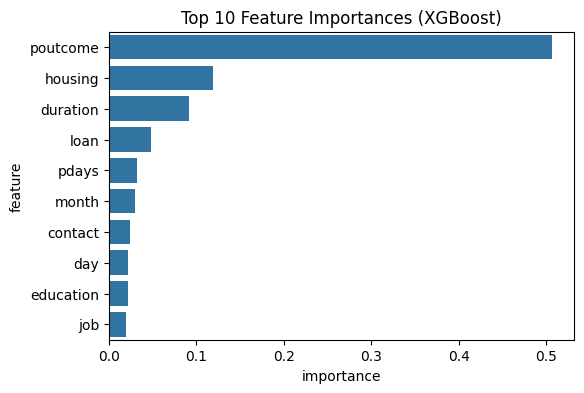


Computing SHAP values. This may be slow for large data.
Using a random sample of 500 from 1569 rows for SHAP.


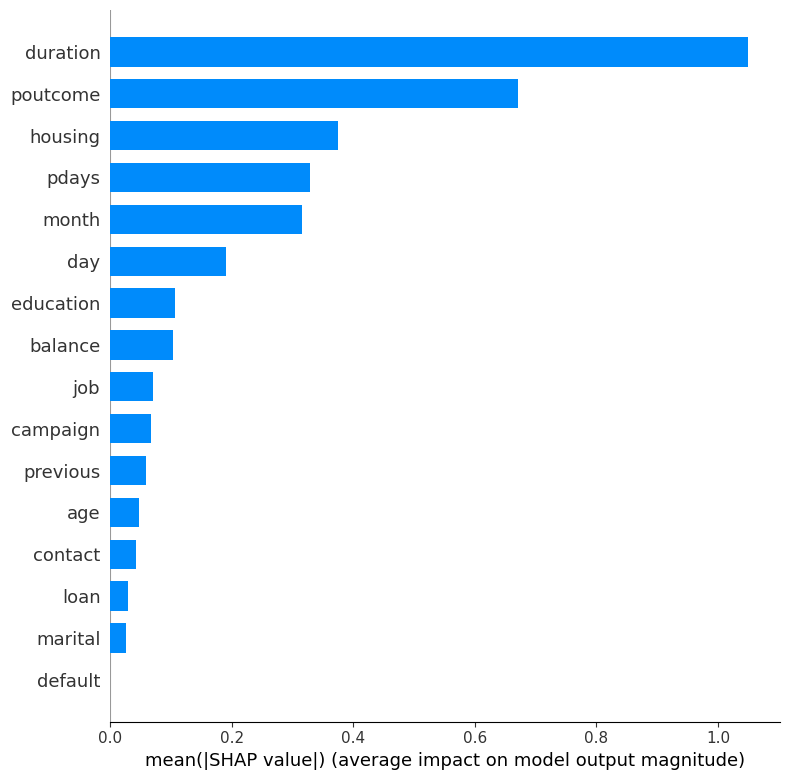

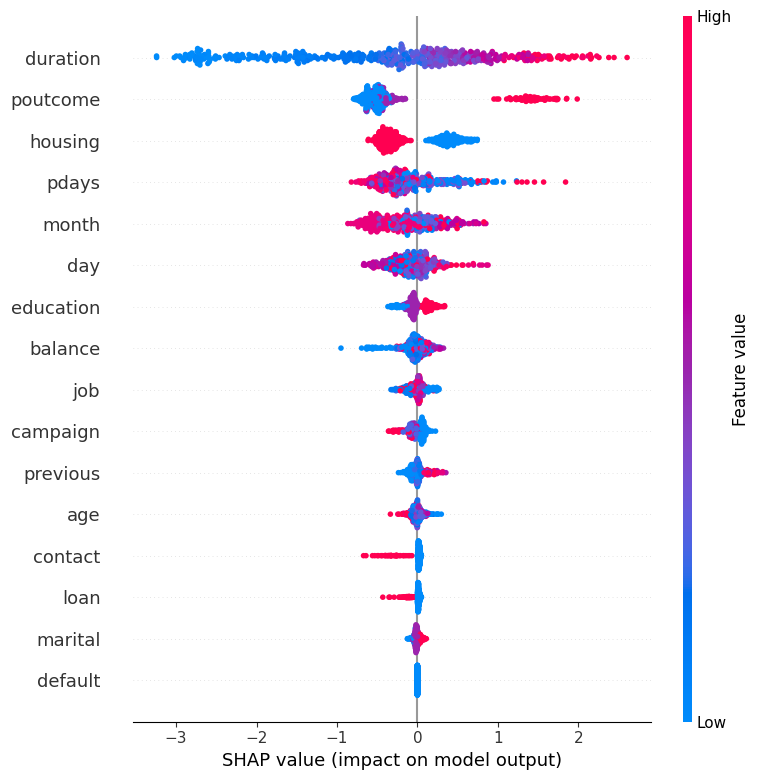


SHAP force plot for the first row in X_sample:


In [15]:
def part3_how_to_personalize(model, X, df):
    """
    Show feature importances and utilize SHAP for deeper interpretability.
    """
    print("\n=== Part 3: How to Personalize Communication? ===")
    
    feature_importances = model.feature_importances_
    feature_names = list(df.drop(columns=['y']).columns)
    
    fi_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    fi_df = fi_df.sort_values('importance', ascending=False)
    
    print("\nTop 10 features (XGBoost importance):")
    print(fi_df.head(10))
    
    plt.figure(figsize=(6,4))
    sns.barplot(x='importance', y='feature', data=fi_df.head(10))
    plt.title("Top 10 Feature Importances (XGBoost)")
    plt.show()
    
    # SHAP
    print("\nComputing SHAP values. This may be slow for large data.")
    explainer = shap.TreeExplainer(model)
    
    # If large dataset, sample
    if len(X) > 500:
        X_sample = X.sample(500, random_state=42)
        print(f"Using a random sample of 500 from {len(X)} rows for SHAP.")
    else:
        X_sample = X
    
    shap_values = explainer.shap_values(X_sample)
    
    # Global bar plot
    shap.summary_plot(shap_values, X_sample, plot_type='bar')
    # Beeswarm
    shap.summary_plot(shap_values, X_sample)
    
    # Local explanation for first row
    print("\nSHAP force plot for the first row in X_sample:")
    display(shap.force_plot(
        explainer.expected_value,
        shap_values[0,:],
        X_sample.iloc[0,:]
    ))

part3_how_to_personalize(best_model, X_test, df_full)


## XGBoost Feature Importances
- poutcome again dominates, with over 50% relative importance.
- housing and duration also stand out, indicating whether a customer owns a house or how long the last call lasted strongly affect their subscription probability.
- loan, pdays, and month appear mid-range, while contact, day, education, and job have smaller relative importance.

**Key Takeaway**
- The raw XGBoost importances underscore that poutcome (previous campaign outcome) is still the single largest driver.
- Duration (the length of the last engagement) is also quite important for personalization strategies. 

## SHAP Summary Plots
I sampled 500 rows for SHAP to manage runtime. The global SHAP bar chart and beeswarm provide deeper insight:
### 1. Global SHAP Bar Plot
- duration ranks #1 in average absolute impact on the model, surpassing even poutcome when measured via SHAP.
  - This suggests that although poutcome is high in XGBoost’s internal measure, duration might be the single largest factor shifting predictions up or down for individual customers.
- poutcome, housing, and pdays also show large average SHAP values.
- month and day have moderate contributions, while factors like loan, balance, and education are somewhat lower.

**Why the difference from XGBoost importances?**
- XGBoost’s built-in importance can be skewed by how often a feature is used in splits.
- SHAP looks at the marginal contribution of each feature across individual predictions, giving a different perspective.

### 2. SHAP Beeswarm Plot
- duration: Higher (pink) values generally push predictions strongly up (to the right on the SHAP axis), meaning longer calls tend to increase the likelihood of subscription.
- poutcome: If the outcome was success in a previous campaign, we’ll see a positive contribution (pushing SHAP to the right). If it was “failure” or “other,” it might push the outcome negative.
- housing: A “yes” might shift the prediction up or down depending on how the model interprets it. Usually, having a housing loan can indicate enough creditworthiness but also the potential for cross-selling.
- pdays: High “pdays” (time since last contact) can either raise or lower subscription probability depending on context in the model.

In the plot, blue points indicate a lower feature value, while pink/red points show a higher feature value. How far they’re shifted left or right indicates whether that feature pushes predictions down or up respectively.

## Local Explanation: SHAP Force Plot

The force plot for a single row (with features like duration=18, month=8, etc.) shows:
- A base value (center) is the average model output (log-odds or probability).
- Features to the left in blue (if negative) are pulling the prediction down; features to the right in red (if positive) are pushing the prediction up.
- Here, for example, duration=18 might be a strong positive driver (pushing the predicted subscription probability higher), while some other factors (like poutcome=0 or housing=1) might shift it slightly one way or the other.

**Takeaway for Personalization**
- You can look at each customer’s SHAP force plot to see what factors (e.g., short call vs. long call, successful past campaigns, having a housing loan) might convince them.
- For those with high duration or previously successful outcomes, a more detailed or engaged conversation may be effective.
- For those with minimal past success or short calls, you might tailor your pitch or allocate more direct follow-up to see if deeper conversations can change their minds.

## Final Recommendations for Personalization
1. Leverage Past Outcomes: If a customer had a successful previous campaign (poutcome=success), highlight continuity or loyalty benefits. If it was failed, refine the pitch to address previous objections.
2. Pay Attention to Call Duration: Customers who talk longer are more receptive—spend resources offering them personalised solutions or highlighting more product details.
3. Housing: If a customer has a housing loan, cross-selling mortgage add-ons or special interest rates might be fruitful. If they don’t, emphasise benefits like new mortgage products or short-term loans.
4. Segment by pdays: If they were contacted recently but didn’t convert, you may need a fresh approach; if it’s been a long time, re-establish the relationship and mention updated offers.
5. Combine with Timing: From Question 2, if you see certain months/days also correlate with higher success, schedule follow-ups for those windows when possible.


# Customers Clusters (Three)
***I am working under assumpiton that we have bugdet for only three marketing campings and we want to indetify three main customer gorups in our data set in order to tailer our marketing message to each group more efficiently.***


=== Part 4: Create 3 Clusters for Marketing Campaigns ===
Cluster assignments added to df['cluster'].
Cluster distribution:
 cluster
0    2764
2    2722
1    2356
Name: count, dtype: int64


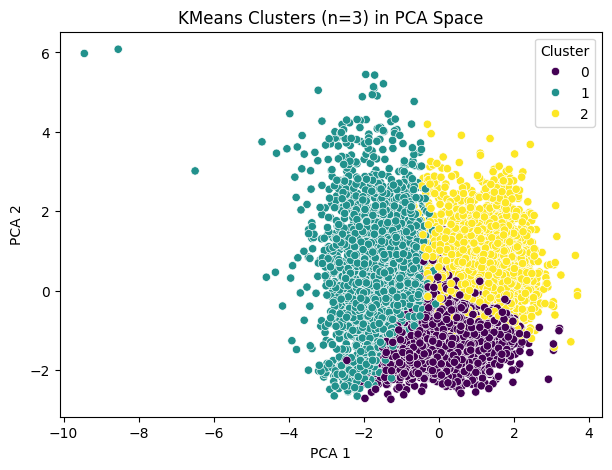

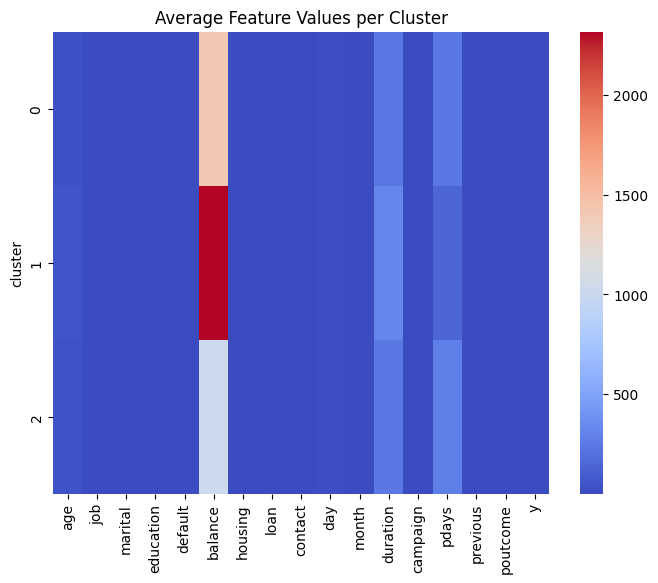

In [16]:
def part4_create_clusters(X, df, n_clusters=3):
    """
    Clusters all customers into 'n_clusters' using KMeans.
    Visualize with PCA scatter plot and a heatmap of average features by cluster.
    """
    print(f"\n=== Part 4: Create {n_clusters} Clusters for Marketing Campaigns ===")
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    df['cluster'] = cluster_labels
    print("Cluster assignments added to df['cluster'].")
    print("Cluster distribution:\n", df['cluster'].value_counts())
    
    # PCA for 2D plotting
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    
    plt.figure(figsize=(7,5))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=cluster_labels, palette='viridis')
    plt.title("KMeans Clusters (n=3) in PCA Space")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend(title='Cluster')
    plt.show()
    
    # Heatmap of average feature values per cluster
    cluster_summary = df.groupby('cluster').mean(numeric_only=True)
    plt.figure(figsize=(8,6))
    sns.heatmap(cluster_summary, cmap='coolwarm')
    plt.title("Average Feature Values per Cluster")
    plt.show()
    
    return cluster_labels

cluster_labels = part4_create_clusters(X, df_full, n_clusters=3)


## Cluster Distribution & PCA Scatter
- Cluster counts:
  - Cluster 0: 2764 customers
  - Cluster 2: 2722 customers
  - Cluster 1: 2356 customers
  
These three groups are fairly balanced in size, so each segment contains a substantial number of customers.

### PCA Scatter Insights
- The 2D PCA projection shows three reasonably distinct “clouds”:
  - Cluster 0 (purple) occupies low negative/low positive PCA1, negative/low PCA2.
  - Cluster 1 (teal) is near negitive PCA1, low negative/hight poisitive PCA2)
  - Cluster 2 (yellow) dominates the middle positive PCA1 region and extends into higher PCA2.
- The slight overlap among clusters is typical, but each color group forms a distinct zone, indicating KMeans found some meaningful separation in the data’s multi-dimensional space.

**Takeaway:**
You have three major segments of customers with different underlying attributes. The PCA projection confirms that clusters are not random but reflect real variance in the feature space.

## Heatmap of Average Feature Values
The heatmap shows mean (or average) values of each feature across the three clusters. Warmer colors (red) indicate higher average values, while cooler colors (blue) indicate lower averages. Here are some highlights:
1. Balance stands out for cluster 1 (red) vs. cluster 2 (lighter blue) vs. cluster 0 (lighter pink).
- This suggests cluster 1 has notably higher average yearly balance.
- cluster 0 might have a moderate average balance, and cluster 2 a lower one.
2. Default is lightly colored for cluster 0, suggesting it might be slightly higher in default rate (or unknown). Double-check the scale and label-encoding, though.
3. Some campaign features (like duration, pdays, previous) show moderate differences but are less stark in the heatmap.
4. Y (the subscription outcome) is uniformly blue across all clusters, implying the average “y” value is low across the dataset (the minority class), so it’s not heavily influencing cluster separation.

**Potential Profiles**
- Cluster 1: Higher balance stands out. Possibly indicates more affluent customers or those with bigger deposits.
- Cluster 0: Could have moderate balances, perhaps more customers with loan or default variations.
- Cluster 2: Might have lower average balances but differs in other features (e.g., day, campaign, or pdays).

## Business Implications
1. Cluster 1 (High-Balance Segment)
- Potentially more profitable to up-sell investment or premium banking products.
- They may be more receptive to complex offers but also have higher expectations of service.
2. Cluster 0 (Moderate Balance, Possibly Different Loan/Default Patterns)
- May benefit from targeted credit consolidation or debt restructuring offers if default or loan usage is higher.
- Focus on alleviating concerns about monthly payments or interest rates.
3. Cluster 2 (Lower Balance or Distinct Behavior)
- Could be cost-sensitive or need simpler, lower-tier products.
- Possibly respond to smaller promotions or short-term deposit incentives.

# Customer Profiles

In [18]:
def build_cluster_profiles(df, 
                          numeric_feats, 
                          categorical_feats, 
                          label_encoders=None, 
                          num_top_jobs=2):
    """
    Generates plain-language summaries for each cluster based on means/medians
    of numeric features and top categories in categorical features.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Must contain 'cluster' column and any numeric/categorical features.
    numeric_feats : list of str
        List of numeric feature column names, e.g. ['age','balance','day','duration',...].
    categorical_feats : list of str
        List of categorical feature column names, e.g. ['job','marital',...].
    label_encoders : dict or None
        (Optional) A dictionary of {col_name: fitted_LabelEncoder} to decode
        categories back to strings. If None, it will use numeric codes as is.
    num_top_jobs : int
        How many top categories to highlight (e.g. top 2 job codes).
        
    Returns:
    --------
    None (prints cluster profiles to console).
    """
    
    if 'cluster' not in df.columns:
        print("No 'cluster' column found in df. Cannot build profiles.")
        return
    
    grouped = df.groupby('cluster')
    
    # Means & medians for numeric features
    mean_df = grouped[numeric_feats].mean().round(2)
    median_df = grouped[numeric_feats].median().round(2)
    
    # Iterate each cluster and build textual summary
    for cluster_id in sorted(df['cluster'].unique()):
        cluster_data = df[df['cluster'] == cluster_id]
        
        # Basic numeric info
        mean_age = median_df.loc[cluster_id, 'age'] if 'age' in median_df.columns else None
        avg_balance = mean_df.loc[cluster_id, 'balance'] if 'balance' in mean_df.columns else None
        median_duration = median_df.loc[cluster_id, 'duration'] if 'duration' in median_df.columns else None
        
        # Loan proportion if 'loan' is in categorical_feats
        loan_prop = None
        if 'loan' in categorical_feats:
            # If we assume 1 => "yes", 0 => "no"
            loan_prop = cluster_data['loan'].value_counts(normalize=True).get(1, 0) * 100
        
        # Start building profile text
        profile_lines = []
        profile_lines.append(f"Cluster {cluster_id}")
        if mean_age is not None:
            profile_lines.append(f"  Age (median): {mean_age}")
        if avg_balance is not None:
            profile_lines.append(f"  Balance (avg): {avg_balance} euros")
        if median_duration is not None:
            profile_lines.append(f"  Duration (median): {median_duration} seconds (last contact)")
        if loan_prop is not None:
            profile_lines.append(f"  Personal Loan: ~{loan_prop:.1f}% have a personal loan")
        
        # Top job categories
        if 'job' in categorical_feats:
            job_counts = cluster_data['job'].value_counts().sort_values(ascending=False)
            total_jobs = job_counts.sum()
            top_jobs = job_counts.head(num_top_jobs)
            top_jobs_sum = top_jobs.sum()
            top_jobs_percent = (top_jobs_sum / total_jobs)*100
            
            def decode_job_code(job_code):
                """If label_encoders provided, decode job codes to strings."""
                if label_encoders and 'job' in label_encoders:
                    return label_encoders['job'].inverse_transform([job_code])[0]
                else:
                    return f"job_code={job_code}"
            
            top_job_strs = []
            for jcode, count in top_jobs.items():
                pct = (count / total_jobs)*100
                decoded = decode_job_code(jcode)
                top_job_strs.append(f"{decoded} ({pct:.1f}%)")
            
            profile_lines.append(
                f"  Top {num_top_jobs} Jobs: {', '.join(top_job_strs)} => ~{top_jobs_percent:.1f}% combined"
            )
        
        # Print out the marketing angle placeholder
        profile_lines.append("  Marketing Angle: *TBD* (Tailor based on cluster's attributes)\n")
        
        # Print the final block for this cluster
        print("\n".join(profile_lines))


def part5_summarize_clusters(df, numeric_features=None, categorical_features=None, label_encoders=None):
    """
    Summarizes each cluster in df with a plain-language approach.
    """
    print("\n=== Part 5: Summarize Clusters ===")
    if 'cluster' not in df.columns:
        print("No 'cluster' column found in df. Please run 'part4_create_clusters' first.")
        return
    
    # If user didn't specify features, we guess them:
    if numeric_features is None:
        numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
        numeric_features = [c for c in numeric_features if c not in ['cluster','y']]
    if categorical_features is None:
        categorical_features = []
    
    # Build the cluster profiles
    build_cluster_profiles(
        df=df,
        numeric_feats=numeric_features,
        categorical_feats=categorical_features,
        label_encoders=label_encoders,
        num_top_jobs=2  # or however many you want
    )


# Example usage after your data is loaded, parted, and clusters assigned:
# If you have stored encoders, pass them in like label_encoders={'job': job_label_encoder, ...}
numeric_feats = ['age','balance','day','duration','campaign','pdays','previous']
cat_feats = ['job','marital','education','default','housing','loan','contact','month','poutcome']

part5_summarize_clusters(
    df_full,
    numeric_features=numeric_feats,
    categorical_features=cat_feats,
    label_encoders=None  # or pass a dict if you have saved encoders
)



=== Part 5: Summarize Clusters ===
Cluster 0
  Age (median): 34.0
  Balance (avg): 1416.43 euros
  Duration (median): 176.0 seconds (last contact)
  Personal Loan: ~6.6% have a personal loan
  Top 2 Jobs: job_code=4 (29.6%), job_code=9 (26.4%) => ~56.0% combined
  Marketing Angle: *TBD* (Tailor based on cluster's attributes)

Cluster 1
  Age (median): 46.0
  Balance (avg): 2318.87 euros
  Duration (median): 239.0 seconds (last contact)
  Personal Loan: ~5.8% have a personal loan
  Top 2 Jobs: job_code=4 (27.5%), job_code=9 (16.0%) => ~43.4% combined
  Marketing Angle: *TBD* (Tailor based on cluster's attributes)

Cluster 2
  Age (median): 41.0
  Balance (avg): 1026.89 euros
  Duration (median): 177.0 seconds (last contact)
  Personal Loan: ~28.3% have a personal loan
  Top 2 Jobs: job_code=1 (43.3%), job_code=0 (20.0%) => ~63.3% combined
  Marketing Angle: *TBD* (Tailor based on cluster's attributes)



# Radar Chart of Radar Chart of Numeric Features per Cluster
**Each cluster is a polygon on the radial axes. If the polygon extends far in a particular feature, it means that cluster’s mean is higher than the other clusters (after normalization).**

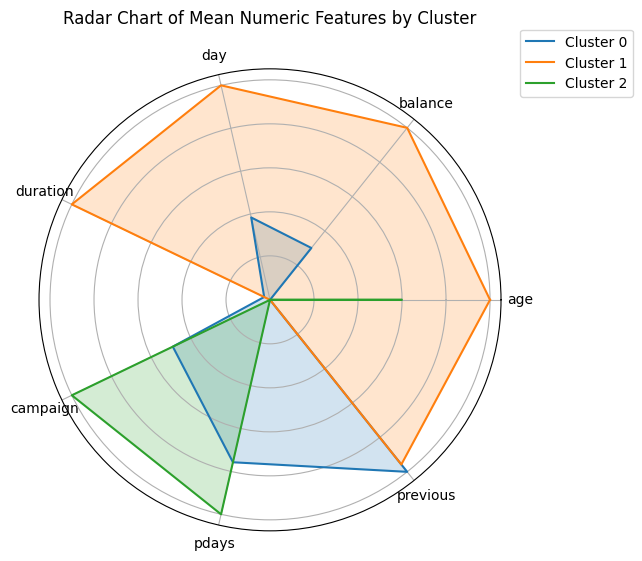

In [23]:
def radar_chart_numeric_features(df, numeric_features):
    
    if 'cluster' not in df.columns:
        print("No 'cluster' column found in df.")
        return
    
    # Group by cluster, compute means
    cluster_summary = df.groupby('cluster')[numeric_features].mean()
    
    # Normalize each feature to [0,1] across clusters for fair comparison
    cluster_summary_norm = (cluster_summary - cluster_summary.min()) / (cluster_summary.max() - cluster_summary.min() + 1e-9)
    
    n_features = len(numeric_features)
    angles = np.linspace(0, 2*np.pi, n_features, endpoint=False).tolist()
    
    fig, ax = plt.subplots(subplot_kw=dict(polar=True), figsize=(7,6))
    
    for cluster_id, row in cluster_summary_norm.iterrows():
        data = row.values
        data = np.concatenate((data, [data[0]]))  # close the polygon
        angle_data = angles + [angles[0]]
        
        ax.plot(angle_data, data, label=f"Cluster {cluster_id}")
        ax.fill(angle_data, data, alpha=0.2)
    
    ax.set_xticks(angles)
    ax.set_xticklabels(numeric_features)
    ax.set_yticklabels([])
    ax.set_title("Radar Chart of Mean Numeric Features by Cluster", y=1.08)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

# Example usage with your numeric features:
numeric_feats = ["age","balance","day","duration","campaign","pdays","previous"]
radar_chart_numeric_features(df_full, numeric_feats)


## Textual Summaries (Cluster 0, 1, 2)
1. Cluster 0
- Age (median): 34
- Balance (avg): 1416.43 euros
- Duration (median): 176.0 seconds (last contact)
- ~6.6% have a personal loan
- Top 2 Jobs: job_code=4 (29.6%), job_code=9 (26.4%) => ~56.0% combined
- Marketing Angle: Younger demographic, mid-level balances, moderate call durations. Perhaps more flexible savings packages, short-term credit, or targeted offers if they have some financial stability (balance ~1,400 euros).

2. Cluster 1
- Age (median): 46
- Balance (avg): 2318.87 euros (highest of the three)
- Duration (median): 239.0 seconds (longest calls)
- ~5.8% have a personal loan (lowest among clusters)
- Top 2 Jobs: job_code=4 (27.5%), job_code=9 (16.0%) => ~43.4% combined
- Marketing Angle: Mid-career or older professionals with higher balances and long call durations. Likely open to detailed product discussions (since they stay on calls longer). Good segment for premium products or in-depth financial solutions.

3. Cluster 2
- Age (median): 41
- Balance (avg): 1026.89 euros (lowest among clusters)
- Duration (median): 177.0 seconds
- ~28.3% have a personal loan (substantially higher)
- Top 2 Jobs: job_code=1 (43.3%), job_code=0 (20.0%) => ~63.3% combined
- Marketing Angle: Mid-range age, lower balances, more personal loans. Possibly more cost-sensitive or debt-laden. Might respond to offers focusing on loan refinancing, short-term credit relief, or simpler, lower-tier banking services.

## Radar (Spider) Chart Interpretation
I plotted the mean of several numeric features for each cluster, normalized so each axis spans 0–1. 
1. This lets us compare how each cluster stands out relative to the others in each dimension:
- Cluster 1 (Orange) extends furthest in balance, duration, and day. This reaffirms that Cluster 1 has the highest average balance, invests more time on calls, and is contacted later in the month (on average).
- Cluster 0 (Blue) stands out on previous (lower end) and possibly has moderate/low values for pdays and campaign.
- Cluster 2 (Green) has a strong extension on campaign and pdays, suggesting they may have been contacted more often in the campaign or had more days since last contact. They also appear to have lower balance and somewhat middle-range on age.

**Takeaway:**
The radar chart visually confirms the textual summary. Where we see the wedge spread out, that cluster is relatively high on that metric (compared to other clusters). If it’s tucked in, that cluster is low on that feature.

## Key Business Implications
1. Cluster 1 (High Balance, Longer Calls):
- Likely more affluent or financially secure.
- Target with sophisticated investment products, potential mortgage expansion, or premium accounts.
2. Cluster 0 (Younger, Mid Balance, Fewer Past Contacts):
- Possibly early in their career.
- Emphasize flexible savings, building credit or small personal loans. Potential to grow loyalty as they age/income increases.
3. Cluster 2 (Lower Balance, More Personal Loans, More Campaign Contacts):
- Possibly budget-conscious or debt-laden.
- Provide tailored solutions to reduce monthly costs, consolidated loan offers, or quick-win promotions.